In this notebook I will extract the density of the functional group that might be in the active layer.


In [1]:
import os
import numpy as np
import pandas as pd
from scipy import signal
from scipy import optimize
from scipy import linalg
from scipy.interpolate import UnivariateSpline
import matplotlib
import matplotlib.pyplot as plt
import array as arr
import seaborn as sns
import random
import pylab
import glob
from scipy import stats
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import datetime
import cartopy.crs as ccrs
import cartopy

import inverse_method_funs as inv
import sb_tools

In [2]:
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

# Read scattering models
Import species backscattering cross section matrix

In [3]:
# Sigmabs from ZooScatR model runs + viscous elactic model for mean of fish larvae model by ve=True)
fname_sim = '../ZooScatStuff/my_simplified_data.feather'

specs, freqs_sim, sig_bs_mean, ci_boot = inv.read_scatteringmodelsimulations(fname_sim, nsim=1000, ve=True)

(2, 801, 3)
(2, 801, 4)


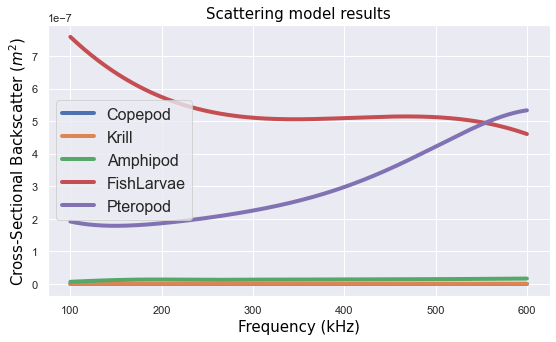

In [5]:
fig=plt.figure(figsize=(9, 5),facecolor='w', edgecolor='k')
plt.plot(freqs_sim,sig_bs_mean, linewidth=4)
plt.legend(specs, fontsize=16)
plt.ylabel('Cross-Sectional Backscatter ($m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Scattering model results', title_font);

# Resample to line up output and input

In [6]:
fname_EV = glob.glob('D:/GLIDER2018/Echosounder/Flaket_SSL/*.csv')

sv_all = np.zeros((820,0))
times = np.zeros((0))

freqs_EV, sv_out_no, times_out_no = inv.read_widebandfrequencyresponse(fname_EV[0])

In [8]:
sigbs_mean = np.zeros([len(freqs_EV),len(specs)])
ci_boot0 = np.zeros([len(freqs_EV),len(specs)])
ci_boot1 = np.zeros([len(freqs_EV),len(specs)])


for ind_spec in range(0,len(specs)):
    sigbs_mean[:,ind_spec] = np.interp(freqs_EV, freqs_sim, sig_bs_mean[:,ind_spec])
    ci_boot0[:,ind_spec] = np.interp(freqs_EV, freqs_sim, ci_boot[0,:,ind_spec])
    ci_boot1[:,ind_spec] = np.interp(freqs_EV, freqs_sim, ci_boot[1,:,ind_spec])

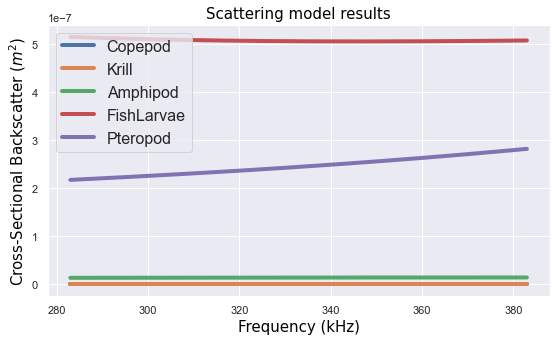

In [9]:
fig=plt.figure(figsize=(9, 5),facecolor='w', edgecolor='k')
plt.plot(freqs_EV,sigbs_mean, linewidth=4)
plt.legend(specs, fontsize=16)
plt.ylabel('Cross-Sectional Backscatter ($m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Scattering model results', title_font);

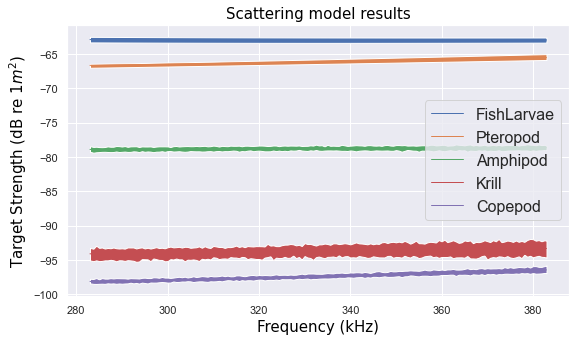

In [19]:
fig=plt.figure(figsize=(9, 5),facecolor='w', edgecolor='k')
order=[3,4,2,1,0]
for ind in [3,4,2,1,0]:
    plt.plot(freqs_EV[:],10*np.log10(sigbs_mean[:,ind]), linewidth=1, label=specs[ind])
    plt.fill_between(freqs_EV[:],10*np.log10(ci_boot0[:,ind]),10*np.log10(ci_boot1[:,ind]))
plt.legend(fontsize=16)
plt.ylabel('Target Strength (dB re $1m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Scattering model results', title_font);

In [32]:
specs[[3]][0]

'FishLarvae'

# IIM
Calculate mean predicted density for each active layer

# Read wideband frequency response
Read the Echoview export of wideband frequency response. sv pulse compressed.

In [65]:
fname_EV = glob.glob('F:/GLIDER2018/Echosounder/Flaket_SSL/*.csv')
nfiles = len(fname_EV)

sv_all = np.zeros((820,0))
times = np.zeros((0))
density = np.zeros((5, nfiles))
sigbs = sigbs_mean
for ind in np.arange(nfiles):
    freqs_EV, sv_out, times_out = inv.read_widebandfrequencyresponse(fname_EV[ind])
    
    density_out = np.zeros([np.shape(sigbs_mean)[1], np.shape(sv_out)[1]])
    for sv_ind in np.arange(np.shape(sv_out)[1]):
        d = optimize.lsq_linear(sigbs, sv_out[:,sv_ind], bounds=(0,np.inf))
        density_out[:,sv_ind] =  d.x

    sv_all = np.append(sv_all, sv_out, axis=1)
    times = np.append(times, times_out[0])
    density[:,ind] = np.mean(density_out,1)

Run a least squares solver

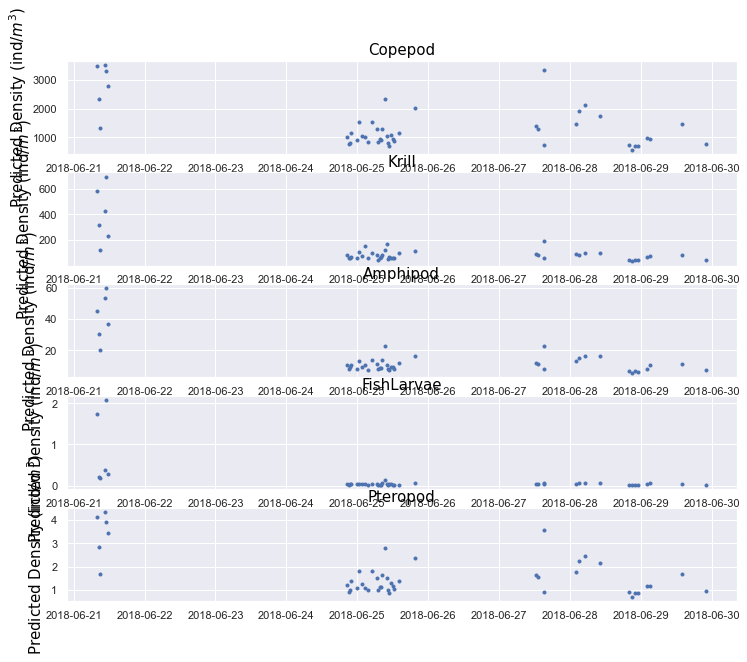

In [66]:
plt.figure(figsize=(12, 12),facecolor='w', edgecolor='k')
plt.ylabel('Predicted Density (ind/$m^3$)', axis_font)
plt.xlabel('Functional group', axis_font)
for ind in range(0,len(specs)):
    plt.subplot(len(specs)+1,1,ind+1)
    plt.plot(times, density[ind,:], '.')
    plt.title(specs[ind], title_font)
    plt.ylabel('Predicted Density (ind/$m^3$)', axis_font)

## Load lat/lon

In [67]:
SB_env_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SB_env_tromsøflaket2018.xlsx',header=0, engine="openpyxl")


In [68]:
SB_env_times = SB_env_df.set_index(['datetime'])

In [69]:
index = []
for ind in range(len(times)):
    ind_index = SB_env_times.index.get_loc(times[ind], method="nearest")
    index = np.append(index, ind_index)

# Make dataframe

In [70]:
data = pd.DataFrame()

for specs_ind in range(len(specs)):
    for ind in range(len(times)):
        SB_env_ind = SB_env_times.index.get_loc(times[ind], method="nearest")
        data = data.append({'lat': SB_env_df['latitude (deg)'][SB_env_ind],
                            'lon': SB_env_df['longitude (deg)'][SB_env_ind],
                            'datetime': times[ind],
                            'density': density[specs_ind,ind],
                            'species': specs[specs_ind],                        
                            'source': 'Acoustics'}, 
                            'ignore_index=True')

## Add net data

In [71]:
SP_stations_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SeaPatchesStations.xlsx',header=0)
tucker_density = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/Tucker Trawl.xlsx', header=79)
multinet_density = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SP_Multinet.xlsx')

In [72]:
#Station 7 from Tucker Trawl
stn = 7
for stn_ind in range(7,17):
    for ind_spec in [0,1,2,3,5]:
        data = data.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                            'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                            'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                            'density': tucker_density['Station ' + str(stn_ind)][ind_spec],
                            'species': tucker_density['Species'][ind_spec],
                            'source': 'TuckerTrawl'}, 
                            'ignore_index=True')
        data = data.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                            'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                            'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                            'density': multinet_density['Stn ' + str(stn_ind)][ind_spec],
                            'species': multinet_density['Species'][ind_spec],
                            'source': 'Multinet'}, 
                            'ignore_index=True')

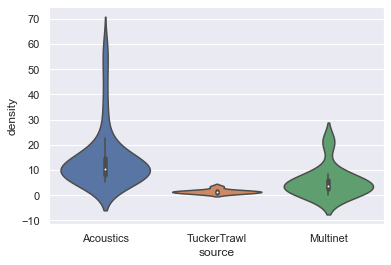

In [73]:
sns.violinplot(data=data[data.species=='Amphipod'], x='source', y='density', scale='width')

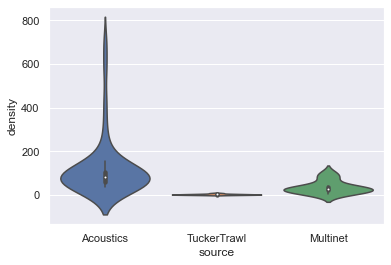

In [74]:
sns.violinplot(data=data[data.species=='Krill'], x='source', y='density', scale='width')

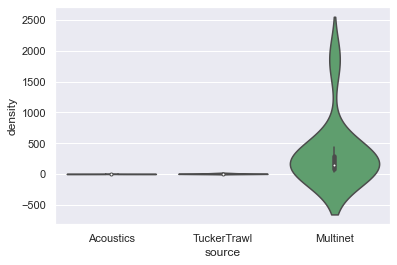

In [75]:
sns.violinplot(data=data[data.species=='Pteropod'], x='source', y='density', scale='width')

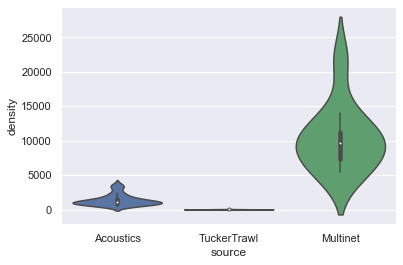

In [76]:
sns.violinplot(data=data[data.species=='Copepod'], x='source', y='density', scale='width')

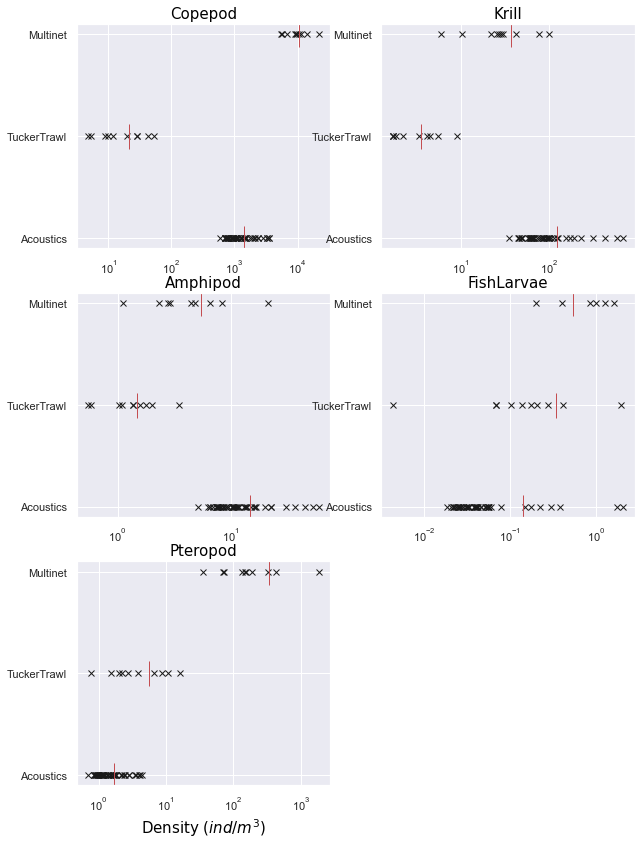

In [77]:
fig = plt.figure(figsize=(10,14))
for ind_spec in range(len(specs)):
    ax = plt.subplot(3,2,ind_spec+1)
    ax.semilogx(data.density[data.species==specs[ind_spec]],data.source[data.species==specs[ind_spec]], 'kx')
    ax.semilogx(data[data.species==specs[ind_spec]].groupby('source').mean()['density'],data[data.species==specs[ind_spec]].groupby('source').mean().index, 'r|', markersize=25)
    ax.set_title(specs[ind_spec], title_font)
ax.set_xlabel('Density ($ind/m^3$)', axis_font);

# Set up per species data

In [78]:
data_spec = pd.DataFrame()

for ind in range(len(times)):
    specs_ind=0
    SB_env_ind = SB_env_times.index.get_loc(times[ind], method="nearest")
    data_spec = data_spec.append({'lat': SB_env_df['latitude (deg)'][SB_env_ind],
                            'lon': SB_env_df['longitude (deg)'][SB_env_ind],
                            'datetime': times[ind],
                            specs[specs_ind]: density[specs_ind, ind],
                            specs[specs_ind+1]: density[specs_ind+1, ind],
                            specs[specs_ind+2]: density[specs_ind+2, ind],
                            specs[specs_ind+3]: density[specs_ind+3, ind],
                            specs[specs_ind+4]: density[specs_ind+4, ind],
                            'source': 'Acoustic'}, 
                            'ignore_index=True')

In [79]:
#Dataframe with all species
for stn_ind in range(7,17):
    data_spec = data_spec.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                        'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                        'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                        tucker_density['Species'][0]: tucker_density['Station ' + str(stn_ind)][0],
                        tucker_density['Species'][1]: tucker_density['Station ' + str(stn_ind)][1],
                        tucker_density['Species'][2]: tucker_density['Station ' + str(stn_ind)][2],
                        tucker_density['Species'][3]: tucker_density['Station ' + str(stn_ind)][3],
                        tucker_density['Species'][5]: tucker_density['Station ' + str(stn_ind)][5],
                        'source': 'TuckerTrawl'}, 
                        'ignore_index=True')
    data_spec = data_spec.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                        'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                        'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                        multinet_density['Species'][0]: multinet_density['Stn ' + str(stn_ind)][0],
                        multinet_density['Species'][1]: multinet_density['Stn ' + str(stn_ind)][1],
                        multinet_density['Species'][2]: multinet_density['Stn ' + str(stn_ind)][2],
                        multinet_density['Species'][3]: multinet_density['Stn ' + str(stn_ind)][3],
                        multinet_density['Species'][5]: multinet_density['Stn ' + str(stn_ind)][5],
                        'source': 'Multinet'}, 
                        'ignore_index=True')

In [80]:
data_spec

,Amphipod,Copepod,FishLarvae,Krill,Pteropod,datetime,lat,lon,source
0,53.317218,3527.214273,0.375762,427.324246,4.333236,2018-06-21 10:31:37,70.830452,18.026430,Acoustic
1,59.713375,3314.182286,2.069999,692.451104,3.913875,2018-06-21 11:01:29,70.826248,18.004681,Acoustic
2,36.648890,2791.679855,0.295521,232.618185,3.424047,2018-06-21 11:31:23,70.825203,18.006540,Acoustic
3,45.435676,3492.578142,1.727458,583.426291,4.122851,2018-06-21 08:01:12,70.832222,18.017429,Acoustic
4,30.420619,2350.249281,0.221068,314.540971,2.824762,2018-06-21 08:31:21,70.832222,18.017429,Acoustic
...,...,...,...,...,...,...,...,...,...
61,2.771429,10670.971429,0.000000,30.209524,154.876190,2018-06-24 02:14:00,70.091000,18.169000,Multinet
62,2.002157,5.316073,0.103560,1.725998,1.518878,2018-06-24 10:57:00,70.525000,18.166000,TuckerTrawl
63,4.840286,5393.234286,0.000000,28.633429,325.102571,2018-06-24 10:57:00,70.525000,18.166000,Multinet
64,0.586839,11.598706,0.172600,4.453074,3.866235,2018-06-25 05:35:00,70.500000,16.936000,TuckerTrawl


In [81]:
data

,datetime,density,lat,lon,source,species
0,2018-06-21 10:31:37,3527.214273,70.830452,18.026430,Acoustics,Copepod
1,2018-06-21 11:01:29,3314.182286,70.826248,18.004681,Acoustics,Copepod
2,2018-06-21 11:31:23,2791.679855,70.825203,18.006540,Acoustics,Copepod
3,2018-06-21 08:01:12,3492.578142,70.832222,18.017429,Acoustics,Copepod
4,2018-06-21 08:31:21,2350.249281,70.832222,18.017429,Acoustics,Copepod
...,...,...,...,...,...,...
325,2018-06-25 05:35:00,1.120000,70.500000,16.936000,Multinet,Amphipod
326,2018-06-25 05:35:00,3.866235,70.500000,16.936000,TuckerTrawl,Pteropod
327,2018-06-25 05:35:00,34.971429,70.500000,16.936000,Multinet,Pteropod
328,2018-06-25 05:35:00,0.172600,70.500000,16.936000,TuckerTrawl,FishLarvae


In [82]:
# Send to R
data.to_feather('.\SSL_density.feather')
data_spec.to_feather('.\SSL_density_spec.feather')

# Compare abundance maps

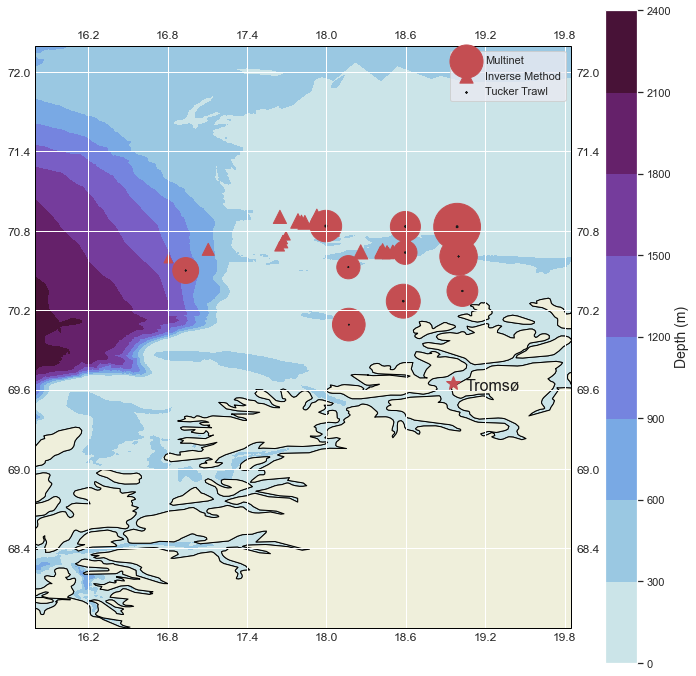

In [83]:
fname_topo = "C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/NordNorgeTopo_tromsoflaket.xlsx"

fig = plt.figure(figsize=(12,12))
ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
data_MT = data[data.source=='Multinet']
plt.scatter(data_MT.lon,data_MT.lat,data_MT.density/10,'r', marker='o', label='Multinet')
data_imm = data[data.source=='Acoustics']
plt.scatter(data_imm.lon,data_imm.lat,data_imm.density/10, 'r', marker='^', label='Inverse Method')
data_TT = data[data.source=='TuckerTrawl']
plt.scatter(data_TT.lon,data_TT.lat,data_TT.density/10, 'k', marker='x', label='Tucker Trawl')
plt.legend()

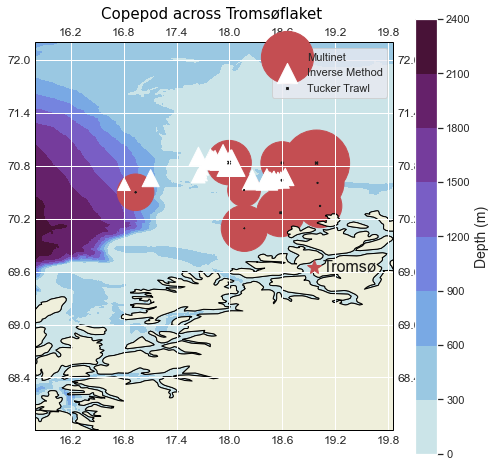

In [122]:
spec = 'Copepod'
MT_spec = data_MT[data_MT['species']==spec]
imm_spec = data_imm[data_imm['species']==spec]
TT_spec = data_TT[data_TT['species']==spec]

fig = plt.figure(figsize=(8,8))

ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
plt.title('%s across Tromsøflaket \n' %spec, title_font)
plt.scatter(MT_spec.lon,MT_spec.lat,MT_spec.density/5,'r', marker='o', label='Multinet')
plt.scatter(imm_spec.lon,imm_spec.lat,imm_spec.density/5, 'w', marker='^', label='Inverse Method')
plt.scatter(TT_spec.lon,TT_spec.lat,TT_spec.density/5, 'k', marker='x', label='Tucker Trawl')
plt.legend()

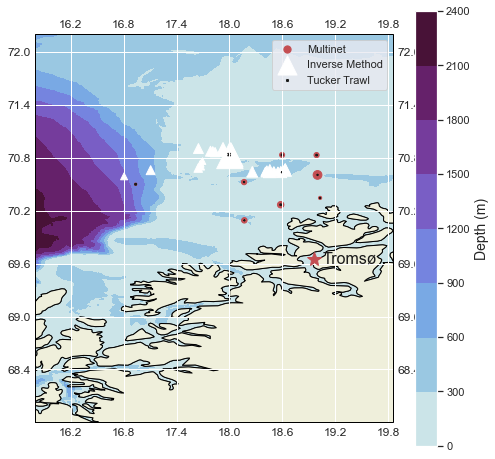

In [123]:
spec = 'Krill'
MT_spec = data_MT[data_MT['species']==spec]
imm_spec = data_imm[data_imm['species']==spec]
TT_spec = data_TT[data_TT['species']==spec]

fig = plt.figure(figsize=(8,8))
plt.title('%s across Tromsøflaket \n' %spec, title_font)
ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
plt.scatter(MT_spec.lon,MT_spec.lat,MT_spec.density,'r', marker='o', label='Multinet')
plt.scatter(imm_spec.lon,imm_spec.lat,imm_spec.density, 'w', marker='^', label='Inverse Method')
plt.scatter(TT_spec.lon,TT_spec.lat,TT_spec.density, 'k', marker='x', label='Tucker Trawl')
plt.legend()

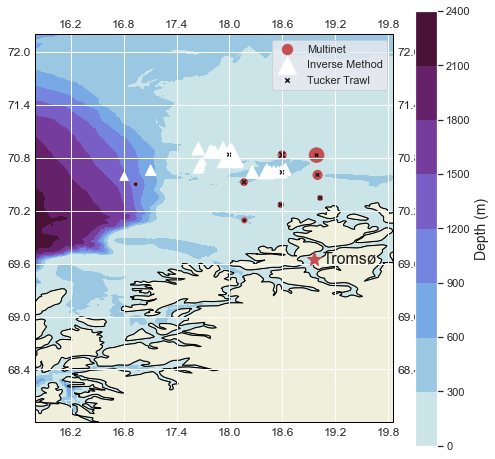

In [116]:
spec = 'Amphipod'
MT_spec = data_MT[data_MT['species']==spec]
imm_spec = data_imm[data_imm['species']==spec]
TT_spec = data_TT[data_TT['species']==spec]

fig = plt.figure(figsize=(8,8))
plt.title('%s across Tromsøflaket \n' %spec, title_font)
ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
plt.scatter(MT_spec.lon,MT_spec.lat,MT_spec.density*10,'r', marker='o', label='Multinet')
plt.scatter(imm_spec.lon,imm_spec.lat,imm_spec.density*10, 'w', marker='^', label='Inverse Method')
plt.scatter(TT_spec.lon,TT_spec.lat,TT_spec.density*10, 'k', marker='x', label='Tucker Trawl')
plt.legend()

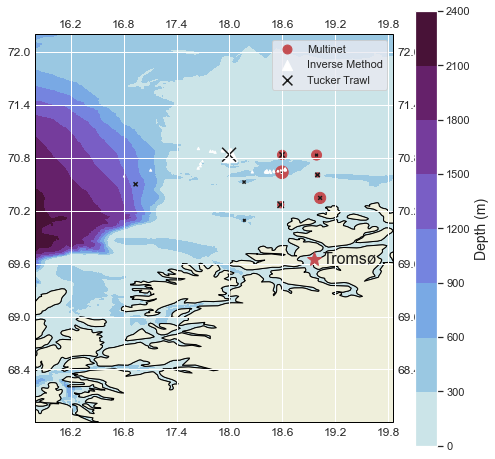

In [120]:
spec = 'FishLarvae'
MT_spec = data_MT[data_MT['species']==spec]
imm_spec = data_imm[data_imm['species']==spec]
TT_spec = data_TT[data_TT['species']==spec]

fig = plt.figure(figsize=(8,8))
plt.title('%s across Tromsøflaket \n' %spec, title_font)
ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
plt.scatter(MT_spec.lon,MT_spec.lat,MT_spec.density*100,'r', marker='o', label='Multinet')
plt.scatter(imm_spec.lon,imm_spec.lat,imm_spec.density*100, 'w', marker='^', label='Inverse Method')
plt.scatter(TT_spec.lon,TT_spec.lat,TT_spec.density*100, 'k', marker='x', label='Tucker Trawl')
plt.legend()

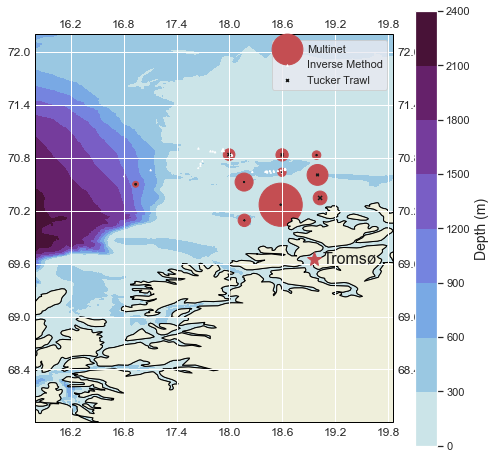

In [119]:
spec = 'Pteropod'
MT_spec = data_MT[data_MT['species']==spec]
imm_spec = data_imm[data_imm['species']==spec]
TT_spec = data_TT[data_TT['species']==spec]

fig = plt.figure(figsize=(8,8))
plt.title('%s across Tromsøflaket \n' %spec, title_font)
ax = sb_tools.plot_tromsoflaket(fig, fname_topo, projection=ccrs.PlateCarree())
plt.scatter(MT_spec.lon,MT_spec.lat,MT_spec.density,'r', marker='o', label='Multinet')
plt.scatter(imm_spec.lon,imm_spec.lat,imm_spec.density, 'w', marker='^', label='Inverse Method')
plt.scatter(TT_spec.lon,TT_spec.lat,TT_spec.density, 'k', marker='x', label='Tucker Trawl')
plt.legend()

# Plot relative abundance comparison

In [86]:
mean_rel_abundance_imm = data_imm.groupby('species').mean()/sum(data_imm.groupby('species').mean()['density'])
mean_rel_abundance_MT = data_MT.groupby('species').mean()/sum(data_MT.groupby('species').mean()['density'])
mean_rel_abundance_TT = data_TT.groupby('species').mean()/sum(data_TT.groupby('species').mean()['density'])

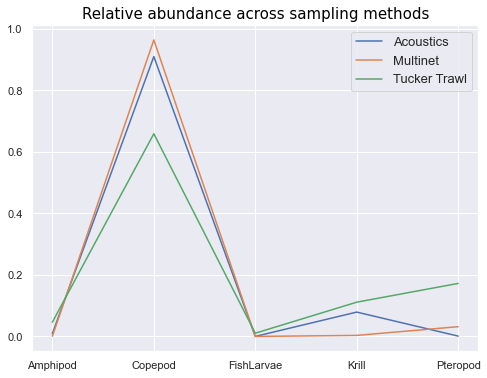

In [87]:
plt.figure(figsize=(8,6))
plt.plot(mean_rel_abundance_imm.index,mean_rel_abundance_imm['density'], label='Acoustics')
plt.plot(mean_rel_abundance_imm.index,mean_rel_abundance_MT['density'], label='Multinet')
plt.plot(mean_rel_abundance_imm.index,mean_rel_abundance_TT['density'], label='Tucker Trawl')
plt.legend(fontsize=13)
plt.title('Relative abundance across sampling methods', title_font);

data_MT.groupby('species').mean()['density']

In [88]:
data_TT.groupby('species').mean()['density']

species
Amphipod       1.487810
Copepod       21.115858
FishLarvae     0.338727
Krill          3.569364
Pteropod       5.523193
Name: density, dtype: float64

In [89]:
data_imm.groupby('species').mean()['density']

species
Amphipod        14.596139
Copepod       1401.423838
FishLarvae       0.140762
Krill          121.958196
Pteropod         1.677229
Name: density, dtype: float64

In [91]:
data_MT.groupby('species').mean()['density']

species
Amphipod          5.450857
Copepod       10416.344505
FishLarvae        0.531429
Krill            36.658095
Pteropod        343.089057
Name: density, dtype: float64

In [98]:
np.mean(data_imm[data_imm['species']=='Krill']['density'])


121.95819610763593

In [124]:
data[data.species=='Krill'].groupby('source').mean()['density']

source
Acoustics      121.958196
Multinet        36.658095
TuckerTrawl      3.569364
Name: density, dtype: float64

In [100]:
10**2

100